# Vorhaben

- ich habe mit den Quelltext einer Webseite runter geladen
    - Meeting-point
    - Künftig möchte ich alle Links der Artike ziehen und mir dann die Texte speichern
    - Bei den Texten die Aufrufzahl notieren
    - Namen von relevaten Personen notieren
- Twitter-Bot, der Analysen (Bild und Text) postet

## Analysen
- Durchschnittliche Länge der Texte der Autoren
- Orte die benannt werden
- Zu welcher Uhrzeit wird welche Kategorie von Artikeln gepostet
- NLP der Texte
- Straßen ziehen und auf Karte setzen
- KOrellationen:
    - Autor - Klickzahlen
    - Artikel-Kategorie - Klickzahlen

## TO-DOs
- Zusammenführen der neuen Daten
    - dabei checken, wenn es alte sind, diese zu erneuern wegen den KLickzahlen

# Protokoll

- **2020.09.06**: Verbindung von Datensätze erstellt
- **2020.09.05**: Neuen Testdatensatz ziehen, nachdem ich Probleme mit dem Autornamen festgestellt habe

In [ ]:
# Probleme
    # Es gibt verschiedene Arten von VOrschauartikel
        # Meldung ohne LInk
        # Meldung mit Link auf Bild
        # Meldung mit Linke auf Artikel (klick oder mehr)



# Weitere Ideen
    # Suchen/Gefunden: Was wird oft gesucht
    # Stellenbörse? Lässt sich da Text rausziehen?

# Einmalig erstellt

In [ ]:
# Speichern der Tabelle
#datensatz.to_csv("datensatz - Kopie.csv",index=False)

# 0 Module laden

In [1]:
from scrapy import Selector
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests # Webseite ziehen
import re
import spacy

In [2]:
# Variablen
url = 'https://meetingpoint-brandenburg.de/'

# regular expresion
muster_publishAndAutor = r'<p>Erstellt: \d*.\d*.\d* / \d*:\d* von [.*]</p>'
muster_autor = r'[\w\/\s-]* \/'

# Datensatz laden
#datensatz = pd.read_csv("datensatz.csv")

# 1 Daten laden

## 1.1 Beginn auf der Startseite

In [3]:
# Create the string html containing the HTML source
html = requests.get( url ).content

# timestamp des Scrapen
ts = datetime.datetime.now()

In [4]:
# Create a Selector selecting html as the HTML document
sel = Selector( text = html )

In [5]:
headlines_first_links = sel.xpath('//div[@class="span6"]/div[@class="span6 article"]').extract()
headlines_parallel_links = sel.xpath('//div[@class="span3 article border-right"]').extract()

In [6]:
# Die Links und Überschriften rausziehen und in einer liste Speichern
beide_listen = headlines_first_links + headlines_parallel_links
print('Artikel gesamt {}'.format(len(beide_listen)))
datastructure_dict_crawl = {'id':[],
                            'Titel':[],
                            'Autor':[],
                            'Publish':[],
                            'pre_view':[],
                            'Link':[],
                            'Date_of_scrape':[]}

# Filter
filter_titel = r'<h1>.*</h1>'
filter_titel_link = r'>.*</a>'


# Listen zum Speichern
titel_liste = []
autor_liste = []
publish_list = []
preText_liste = []
link_liste = []

for i in range(0, len(beide_listen)):
    # Titel ziehen
    #---------------
    temp_sel = Selector( text = beide_listen[i])
    
    # Titel ziehen
    #-------------
    temp_value = temp_sel.xpath('//h1').extract()
    temp_value = temp_value[0][4:-5]
    
    # Wenn ein LInk davor ist, diesen rausfiltern
    if '<a href' in temp_value[:7]:
        temp_value = re.findall(filter_titel_link, temp_value)
        temp_value = temp_value[0][1:-4]
    titel_liste.append(temp_value)
    
    
    # Autor und Datum ziehen
    #-----------------------
    # Erst mal die Zeile ziehen
    temp_value = temp_sel.xpath('//p[@class="name_time"]/text()').extract()
    
    # den Autor finden
    temp_value2 = re.findall(muster_autor, temp_value[0])
    
    # Das Datum finden
    temp_value = re.findall(r'\/ \d{2}.\d{2}. / \d{2}:\d{2}', temp_value[0])
    
    
    temp_value2 = temp_value2[0][:-2]
    temp_value = temp_value[0][2:-8] + '2020 ' + temp_value[0][11:]
    
    
    publish_list.append(datetime.datetime.strptime(temp_value, '%d.%m.%Y %H:%M'))
    autor_liste.append(temp_value2)
    
    
    # preview ziehen
    #---------------
    temp_value = temp_sel.xpath('//p[2]/text()').extract()
    if [' '] == temp_value:
        temp_value[0] = 'kein Text'
    
    preText_liste.append(temp_value[0])
    
    # Links ziehen
    #--------------
    temp_value = temp_sel.xpath('//p[2]/a').extract()
    
    if temp_value == []:
        temp_value = 'kein Link' 
    
    elif temp_value[0][:13] == '<a href="http':
        temp_value = 'kein Link'
    else:
        temp_value = re.findall(r'\".*\"', temp_value[0])
        # Die Anführungstriche entfernen und die url-Adresse vorsetzen
        temp_value = url[:-1] + temp_value[0][1:-1]
    
    link_liste.append(temp_value)
    
    # Output
    nachricht = "Fertig:" + str(i)
    print(nachricht, end="\r")


# Scrape datum hinzufügen
print('Datum hinzufügen', end="\r")
scrape_date = []
for i in range(0, len(titel_liste)):
    scrape_date.append(ts)

# id liste genereiene
id_liste = []
for i in range(0, len(titel_liste)):
    id_liste.append(i)

# Dictionary erstellen
#----------------------
print("Dictionary erstellen", end="\r")
datastructure_dict_crawl['id'] = id_liste
datastructure_dict_crawl['Titel'] = titel_liste
datastructure_dict_crawl['pre_view'] = preText_liste
datastructure_dict_crawl['Link'] = link_liste
datastructure_dict_crawl['Autor'] = autor_liste
datastructure_dict_crawl['Publish'] = publish_list
datastructure_dict_crawl['Date_of_scrape'] = scrape_date

# Dataframe erstellen
df_crawl = pd.DataFrame(datastructure_dict_crawl)


# Artikel laden
#----------------
print("Artikel laden", end="\r")
df_crawl['full_Article'] = 'kein Artikel'

for i in range(0, len(datastructure_dict_crawl['Link'])):
    if datastructure_dict_crawl['Link'][i] == 'kein Link':
        continue
    temp_full_html = requests.get( datastructure_dict_crawl['Link'][i] ).content
    temp_sel = Selector( text = temp_full_html )
    temp_value = temp_sel.xpath('//div[@class="span6 article"]').extract()

    df_crawl['full_Article'][i] = temp_value[0]


# Aufrufe herausfiltern
#------------------------
print("Aufrufe auslesen", end="\r")
df_crawl['aufrufe'] = float='NaN'
for i in range(0, len(df_crawl)):
    # Artikel ziehen
    temp_value = df_crawl['full_Article'][i]
    
    if temp_value == 'kein Artikel':
        continue
    
    # Überschrift finden und kürzen
    temp_value = re.findall(r'<small>Dieser Artikel wurde bereits \d* mal aufgerufen.</small>', temp_value)
    
    temp_value = re.findall(r'\d+', temp_value[0])
    
    # dem Df hinzufügen
    df_crawl['aufrufe'][i] = temp_value[0]


# Arikel -Kategorie extrahieren
#---------------------------------
print("Artikelkategorien", end="\r")
df_crawl['article_category'] = 'keine Kategorie'

for i in range(0, len(df_crawl)):
    # Artikel ziehen
    temp_value = df_crawl['full_Article'][i]
    
    if temp_value == 'kein Artikel':
        continue
    

    # Kategory finden und kürzen
    #print(i,temp_value)
    temp_value = re.findall(r'Druckansicht</a>\n<p.*', temp_value)
    
    # Näher suchen
    temp_value = re.findall(r'<p>[\w-]*</p>', temp_value[0])
    
    # AUsschneiden
    temp_value = temp_value[0][3:-4]

    # dem Df hinzufügen
    df_crawl['article_category'][i] = temp_value

# Text-variable erstellen
#-------------------------
print("Text erstellen", end="\r")
df_crawl['full_text'] = 'kein Text'

for i in  range(0, len(df_crawl['full_Article'])):
    if df_crawl['full_Article'][i] == 'kein Artikel':
        if df_crawl['pre_view'][i] == 'kein Text':
            continue
        else:
            df_crawl['full_text'][i] = df_crawl['pre_view'][i]
            continue
    
    text = ''
    
    temp_sel = Selector( text = df_crawl['full_Article'][i] )
    temp_preText = temp_sel.xpath('//p/em/text()').extract()
    temp_text = temp_sel.xpath('//p[4]/text()').extract()
    
    # die Textfragmente zusammensetzen
    for j in range(0, len(temp_preText)):

        text += temp_preText[j] + "\n"
    
    for j in range(0, len(temp_text)):
        text += temp_text[j] + "\n"
    
    df_crawl['full_text'][i] = text

Artikel gesamt 60


C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-pac

## 1.2 Datensätze zusammenführen

In [7]:
# Alten Datensatz laden
alt_crawl = pd.read_csv("datensatz_crawl.csv", parse_dates=['Publish', 'Date_of_scrape'])

In [8]:
# Datensätze zusammenfügen und doppelte Fälle löschen
df_crawl = pd.concat([alt_crawl, df_crawl])

# Doppelte Fälle löschen, bzw. Fallzahlenaktualisieren
df_crawl.drop_duplicates(subset =['Titel', 'Link'], 
                     keep = 'last', inplace = True)

# Index anpassen
df_crawl.reset_index(drop=True)

,id,Titel,Autor,Publish,pre_view,Link,Date_of_scrape,full_Article,aufrufe,article_category,full_text
0,21,"Saisonstart am Theater: ""Besucher freuen sich ...",cg1,2020-09-04 08:20:00,Am Brandenburger Theater startet die neue Spie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",428,Interview,Am Brandenburger Theater startet die neue Spie...
1,22,25% auf Pizza Rustica bei MC Via,Anzeige,2020-09-04 08:04:00,Wir spendieren 25% Rabatt auf unsere Angebotsp...,kein Link,2020-09-05 17:05:18.946260,kein Artikel,NaN,keine Kategorie,Wir spendieren 25% Rabatt auf unsere Angebotsp...
2,23,Mit dem Transporter auf der Landstraße übersch...,cg1,2020-09-04 07:08:00,Ein Mittelmärker (31) ist Mittwoch am späten N...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",5160,Regionales,Ein Mittelmärker (31) ist Mittwoch am späten N...
3,24,"Schulungsreihe „Hilfe beim Helfen"" im Asklepio...",cg1,2020-09-04 06:33:00,"Die Schulungsreihe „Hilfe beim Helfen"" richtet...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",539,Stadtgeschehen,"Die Schulungsreihe „Hilfe beim Helfen"" richtet..."
4,25,"Ministerium fördert: 900.000 Euro für das ÜAZ,...",cg1,2020-09-03 20:40:00,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",926,Stadtgeschehen,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...
...,...,...,...,...,...,...,...,...,...,...,...
283,55,INTERSPORT Hübner in Wust: ALLES-muss-RAUS-Ver...,Anzeige,2020-09-12 07:00:00,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...
284,56,Bauarbeiten abgeschlossen: Renaissancebau Reck...,rp,2020-09-11 19:00:00,"Der seit Mitte 2017 umfassend sanierte, umgeba...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",815,Regionales,"Der seit Mitte 2017 umfassend sanierte, umgeba..."
285,57,regiobus Potsdam Mittelmark GmbH: Jetzt bewerben!,Anzeige,2020-09-11 18:01:00,Zum 1. Dezember 2020 suchen wir eine Assistenz...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Zum 1. Dezember 2020 suchen wir eine Assistenz...
286,58,Ministerin begrüßt neuen THW-Jahrgang,cg1,2020-09-11 16:38:00,Am 22. September begrüßt die Bundesministerin ...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",813,Stadtgeschehen,Am 22. September begrüßt die Bundesministerin ...


In [9]:
df_crawl

,id,Titel,Autor,Publish,pre_view,Link,Date_of_scrape,full_Article,aufrufe,article_category,full_text
0,21,"Saisonstart am Theater: ""Besucher freuen sich ...",cg1,2020-09-04 08:20:00,Am Brandenburger Theater startet die neue Spie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",428,Interview,Am Brandenburger Theater startet die neue Spie...
1,22,25% auf Pizza Rustica bei MC Via,Anzeige,2020-09-04 08:04:00,Wir spendieren 25% Rabatt auf unsere Angebotsp...,kein Link,2020-09-05 17:05:18.946260,kein Artikel,NaN,keine Kategorie,Wir spendieren 25% Rabatt auf unsere Angebotsp...
2,23,Mit dem Transporter auf der Landstraße übersch...,cg1,2020-09-04 07:08:00,Ein Mittelmärker (31) ist Mittwoch am späten N...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",5160,Regionales,Ein Mittelmärker (31) ist Mittwoch am späten N...
3,24,"Schulungsreihe „Hilfe beim Helfen"" im Asklepio...",cg1,2020-09-04 06:33:00,"Die Schulungsreihe „Hilfe beim Helfen"" richtet...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",539,Stadtgeschehen,"Die Schulungsreihe „Hilfe beim Helfen"" richtet..."
4,25,"Ministerium fördert: 900.000 Euro für das ÜAZ,...",cg1,2020-09-03 20:40:00,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",926,Stadtgeschehen,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...
...,...,...,...,...,...,...,...,...,...,...,...
55,55,INTERSPORT Hübner in Wust: ALLES-muss-RAUS-Ver...,Anzeige,2020-09-12 07:00:00,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...
56,56,Bauarbeiten abgeschlossen: Renaissancebau Reck...,rp,2020-09-11 19:00:00,"Der seit Mitte 2017 umfassend sanierte, umgeba...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",815,Regionales,"Der seit Mitte 2017 umfassend sanierte, umgeba..."
57,57,regiobus Potsdam Mittelmark GmbH: Jetzt bewerben!,Anzeige,2020-09-11 18:01:00,Zum 1. Dezember 2020 suchen wir eine Assistenz...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Zum 1. Dezember 2020 suchen wir eine Assistenz...
58,58,Ministerin begrüßt neuen THW-Jahrgang,cg1,2020-09-11 16:38:00,Am 22. September begrüßt die Bundesministerin ...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",813,Stadtgeschehen,Am 22. September begrüßt die Bundesministerin ...


## 1.3 Datensatz speichern

In [10]:
df_crawl.to_csv("datensatz_crawl.csv",index=False)

# Arbeit mit aktuellen Datensatz

In [11]:
# Laden
df_analyse01 = pd.read_csv("datensatz_crawl.csv", parse_dates=['Publish', 'Date_of_scrape'])
df_analyse01

,id,Titel,Autor,Publish,pre_view,Link,Date_of_scrape,full_Article,aufrufe,article_category,full_text
0,21,"Saisonstart am Theater: ""Besucher freuen sich ...",cg1,2020-09-04 08:20:00,Am Brandenburger Theater startet die neue Spie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",428.0,Interview,Am Brandenburger Theater startet die neue Spie...
1,22,25% auf Pizza Rustica bei MC Via,Anzeige,2020-09-04 08:04:00,Wir spendieren 25% Rabatt auf unsere Angebotsp...,kein Link,2020-09-05 17:05:18.946260,kein Artikel,NaN,keine Kategorie,Wir spendieren 25% Rabatt auf unsere Angebotsp...
2,23,Mit dem Transporter auf der Landstraße übersch...,cg1,2020-09-04 07:08:00,Ein Mittelmärker (31) ist Mittwoch am späten N...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",5160.0,Regionales,Ein Mittelmärker (31) ist Mittwoch am späten N...
3,24,"Schulungsreihe „Hilfe beim Helfen"" im Asklepio...",cg1,2020-09-04 06:33:00,"Die Schulungsreihe „Hilfe beim Helfen"" richtet...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",539.0,Stadtgeschehen,"Die Schulungsreihe „Hilfe beim Helfen"" richtet..."
4,25,"Ministerium fördert: 900.000 Euro für das ÜAZ,...",cg1,2020-09-03 20:40:00,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",926.0,Stadtgeschehen,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...
...,...,...,...,...,...,...,...,...,...,...,...
283,55,INTERSPORT Hübner in Wust: ALLES-muss-RAUS-Ver...,Anzeige,2020-09-12 07:00:00,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...
284,56,Bauarbeiten abgeschlossen: Renaissancebau Reck...,rp,2020-09-11 19:00:00,"Der seit Mitte 2017 umfassend sanierte, umgeba...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",815.0,Regionales,"Der seit Mitte 2017 umfassend sanierte, umgeba..."
285,57,regiobus Potsdam Mittelmark GmbH: Jetzt bewerben!,Anzeige,2020-09-11 18:01:00,Zum 1. Dezember 2020 suchen wir eine Assistenz...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Zum 1. Dezember 2020 suchen wir eine Assistenz...
286,58,Ministerin begrüßt neuen THW-Jahrgang,cg1,2020-09-11 16:38:00,Am 22. September begrüßt die Bundesministerin ...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",813.0,Stadtgeschehen,Am 22. September begrüßt die Bundesministerin ...


In [12]:
# dictionary mit weiteren Kategorien
category_dict = {'Verkehr':['Blitzer-Meldung', 'Stau', 'Fuß vom Gas', 'Umleitung', 'Unfall', 'A2'],
                'Jobangebot':['(m/w/d)', 'Verstärkung gesucht', 'bewerben', 'Mitarbeiter gesucht'],
                'Meeting mit Tobi':['Meeting mit Tobi'],
                'Kriminalität':['gestohlen', 'brutal', 'Messerangriff', 'Mordkommission', 'Ermittlung', 'Ladendieb'],
                'Werbung':['Angebote der Woche', 'EDEKA']}

Orte_liste =['Hohenstücken', 'Nord', 'Scholle']
Kolumnen = ['Fünf Fragen - Fünf Antworten',
            'Meeting mit Tobi',
            'Unsere Läden, unsere Leute']

# 3 Data Preparing

## 3.1 Neuen Datensatz für Analysen

In [13]:
#df_crawl.set_index('Publish', inplace=True)

# 4 Analysen

## 4.1 Autoren analyse

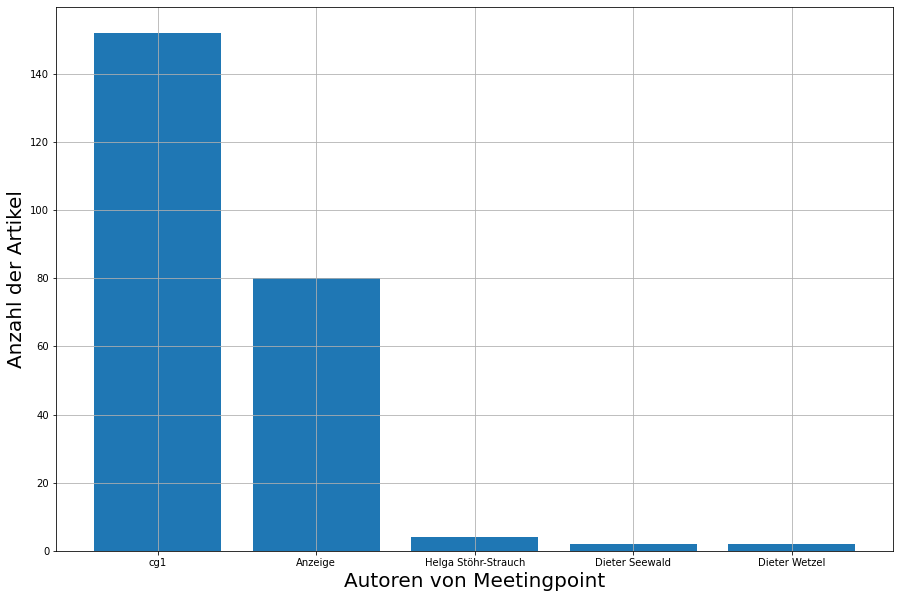

In [14]:
Autoren_df = df_analyse01['Autor'].value_counts()
#print(Autoren_df)

# Visualisieren

fig, ax = plt.subplots(figsize=(15,10))
#fig = plt.figure(figsize=(20,20))

ax.bar(Autoren_df.index[:5], Autoren_df[:5])

ax.set_xlabel('Autoren von Meetingpoint', fontsize=20)
ax.set_ylabel('Anzahl der Artikel', fontsize=20)
ax.grid(True)

plt.show()

## 4.2 Anzahl der Artikel im Zeitverlauf

In [15]:
# Index auf Datum setzen
df_analyse01_tdi = df_analyse01.copy()
df_analyse01_tdi.set_index('Publish', inplace=True)

In [16]:
# Variable, die einfach Wert 1 enthält, um zu zeigen, dass es einen Wert gibt
df_analyse01_tdi['zählervariable'] = 1

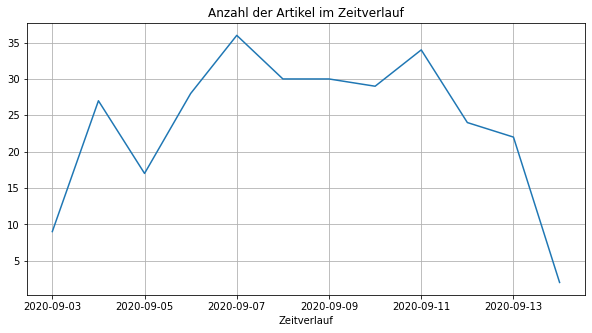

In [17]:
# SUbdatensatz erstellen
Artikel_df = df_analyse01_tdi['zählervariable']

Artikel_df = Artikel_df.resample('D').sum()
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(Artikel_df.index, Artikel_df)
ax.set_title("Anzahl der Artikel im Zeitverlauf")
ax.set_xlabel("Zeitverlauf")
ax.grid()

plt.show()

**Erkenntnis**
- **13.09.2020**: Scheinbar gibt es Montags und Freitags die meisten Artikel

In [18]:
df_analyse01

,id,Titel,Autor,Publish,pre_view,Link,Date_of_scrape,full_Article,aufrufe,article_category,full_text
0,21,"Saisonstart am Theater: ""Besucher freuen sich ...",cg1,2020-09-04 08:20:00,Am Brandenburger Theater startet die neue Spie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",428.0,Interview,Am Brandenburger Theater startet die neue Spie...
1,22,25% auf Pizza Rustica bei MC Via,Anzeige,2020-09-04 08:04:00,Wir spendieren 25% Rabatt auf unsere Angebotsp...,kein Link,2020-09-05 17:05:18.946260,kein Artikel,NaN,keine Kategorie,Wir spendieren 25% Rabatt auf unsere Angebotsp...
2,23,Mit dem Transporter auf der Landstraße übersch...,cg1,2020-09-04 07:08:00,Ein Mittelmärker (31) ist Mittwoch am späten N...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",5160.0,Regionales,Ein Mittelmärker (31) ist Mittwoch am späten N...
3,24,"Schulungsreihe „Hilfe beim Helfen"" im Asklepio...",cg1,2020-09-04 06:33:00,"Die Schulungsreihe „Hilfe beim Helfen"" richtet...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",539.0,Stadtgeschehen,"Die Schulungsreihe „Hilfe beim Helfen"" richtet..."
4,25,"Ministerium fördert: 900.000 Euro für das ÜAZ,...",cg1,2020-09-03 20:40:00,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",926.0,Stadtgeschehen,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...
...,...,...,...,...,...,...,...,...,...,...,...
283,55,INTERSPORT Hübner in Wust: ALLES-muss-RAUS-Ver...,Anzeige,2020-09-12 07:00:00,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...
284,56,Bauarbeiten abgeschlossen: Renaissancebau Reck...,rp,2020-09-11 19:00:00,"Der seit Mitte 2017 umfassend sanierte, umgeba...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",815.0,Regionales,"Der seit Mitte 2017 umfassend sanierte, umgeba..."
285,57,regiobus Potsdam Mittelmark GmbH: Jetzt bewerben!,Anzeige,2020-09-11 18:01:00,Zum 1. Dezember 2020 suchen wir eine Assistenz...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Zum 1. Dezember 2020 suchen wir eine Assistenz...
286,58,Ministerin begrüßt neuen THW-Jahrgang,cg1,2020-09-11 16:38:00,Am 22. September begrüßt die Bundesministerin ...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",813.0,Stadtgeschehen,Am 22. September begrüßt die Bundesministerin ...


## 4.3 Anzahl der Artikelarten im Zeitverlauf

- für jeden Artikel einen Supplot mit Zeitgrafen und gleichen y-Achsen größe

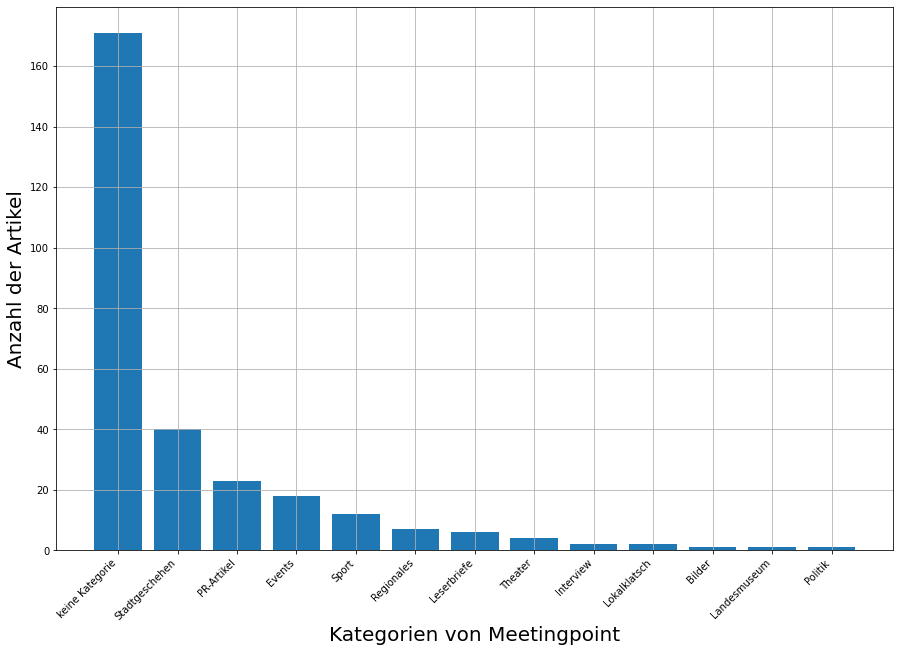

In [19]:
kategorien_df = df_analyse01['article_category'].value_counts()
kategorien_df

# Visualisieren

fig, ax = plt.subplots(figsize=(15,10))
#fig = plt.figure(figsize=(20,20))

ax.bar(kategorien_df.index, kategorien_df)

ax.set_xlabel('Kategorien von Meetingpoint', fontsize=20)
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/timeline.html#sphx-glr-gallery-lines-bars-and-markers-timeline-py
plt.xticks(rotation=45, ha='right')
ax.set_ylabel('Anzahl der Artikel', fontsize=20)
ax.grid(True)

plt.show()

## 4.4 NLP

Quellen: https://blog.codecentric.de/2019/03/natural-language-processing-basics/

In [20]:
# Nur Artikel mit Text nehmen
nlp_df = df_analyse01[df_analyse01['full_text'] != "kein Text"]
nlp_df.reset_index(drop=True)

,id,Titel,Autor,Publish,pre_view,Link,Date_of_scrape,full_Article,aufrufe,article_category,full_text
0,21,"Saisonstart am Theater: ""Besucher freuen sich ...",cg1,2020-09-04 08:20:00,Am Brandenburger Theater startet die neue Spie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",428.0,Interview,Am Brandenburger Theater startet die neue Spie...
1,22,25% auf Pizza Rustica bei MC Via,Anzeige,2020-09-04 08:04:00,Wir spendieren 25% Rabatt auf unsere Angebotsp...,kein Link,2020-09-05 17:05:18.946260,kein Artikel,NaN,keine Kategorie,Wir spendieren 25% Rabatt auf unsere Angebotsp...
2,23,Mit dem Transporter auf der Landstraße übersch...,cg1,2020-09-04 07:08:00,Ein Mittelmärker (31) ist Mittwoch am späten N...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",5160.0,Regionales,Ein Mittelmärker (31) ist Mittwoch am späten N...
3,24,"Schulungsreihe „Hilfe beim Helfen"" im Asklepio...",cg1,2020-09-04 06:33:00,"Die Schulungsreihe „Hilfe beim Helfen"" richtet...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",539.0,Stadtgeschehen,"Die Schulungsreihe „Hilfe beim Helfen"" richtet..."
4,25,"Ministerium fördert: 900.000 Euro für das ÜAZ,...",cg1,2020-09-03 20:40:00,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-05 17:05:18.946260,"<div class=""span6 article"">\n<span id=""url_pri...",926.0,Stadtgeschehen,Im Rahmen des Sonderprogramms „ÜBS-Digitalisie...
...,...,...,...,...,...,...,...,...,...,...,...
276,55,INTERSPORT Hübner in Wust: ALLES-muss-RAUS-Ver...,Anzeige,2020-09-12 07:00:00,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Bei INTERSPORT Hübner im EKZ Wust läuft der gr...
277,56,Bauarbeiten abgeschlossen: Renaissancebau Reck...,rp,2020-09-11 19:00:00,"Der seit Mitte 2017 umfassend sanierte, umgeba...",https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",815.0,Regionales,"Der seit Mitte 2017 umfassend sanierte, umgeba..."
278,57,regiobus Potsdam Mittelmark GmbH: Jetzt bewerben!,Anzeige,2020-09-11 18:01:00,Zum 1. Dezember 2020 suchen wir eine Assistenz...,kein Link,2020-09-14 07:03:03.623760,kein Artikel,NaN,keine Kategorie,Zum 1. Dezember 2020 suchen wir eine Assistenz...
279,58,Ministerin begrüßt neuen THW-Jahrgang,cg1,2020-09-11 16:38:00,Am 22. September begrüßt die Bundesministerin ...,https://meetingpoint-brandenburg.de/neuigkeite...,2020-09-14 07:03:03.623760,"<div class=""span6 article"">\n<span id=""url_pri...",813.0,Stadtgeschehen,Am 22. September begrüßt die Bundesministerin ...


In [21]:
# filter stellen für Autoren, die mehr als einen Artikel haben
filter_list = []
for i in nlp_df.index:
    if pd.isnull(nlp_df['Autor'][i]):
        filter_list.append(False)
    elif Autoren_df.loc[nlp_df['Autor'][i]] > 1:
        filter_list.append(True)
    else:
        filter_list.append(False)

In [22]:
nlp_df_more1 = nlp_df[filter_list]

C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


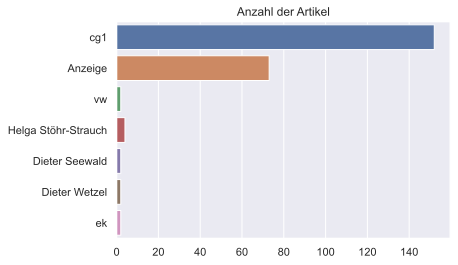

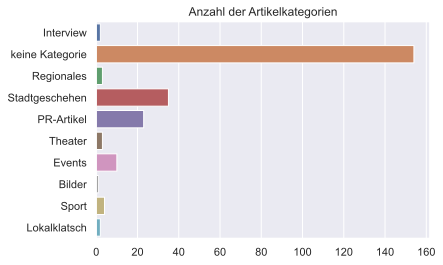

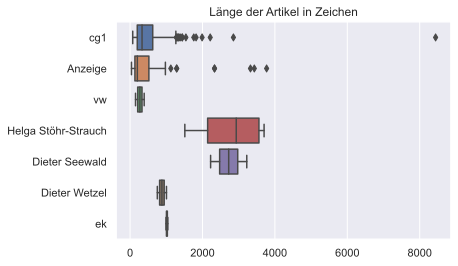

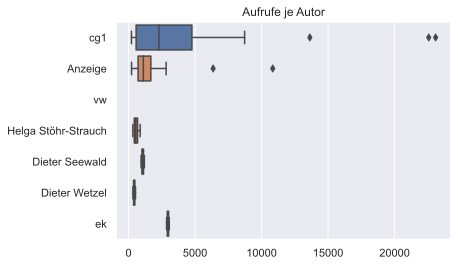

In [23]:
%matplotlib inline
%config InlineBackend.figure_format ='svg'
sns.set()

# Zeichanzahl
nlp_df['length_text'] = nlp_df.full_text.str.len()
nlp_df_more1['length_text'] = nlp_df_more1.full_text.str.len()

sns.countplot(y='Autor', data=nlp_df_more1).set(title="Anzahl der Artikel", xlabel="", ylabel='')
plt.show()
sns.countplot(y='article_category', data=nlp_df_more1).set(title="Anzahl der Artikelkategorien", xlabel="", ylabel='')
plt.show()
sns.boxplot(y='Autor', x='length_text', data=nlp_df_more1).set(title='Länge der Artikel in Zeichen', xlabel="", ylabel='')
plt.show()

sns.boxplot(y='Autor', x='aufrufe', data=nlp_df_more1).set(title='Aufrufe je Autor', xlabel="", ylabel='')
plt.show()

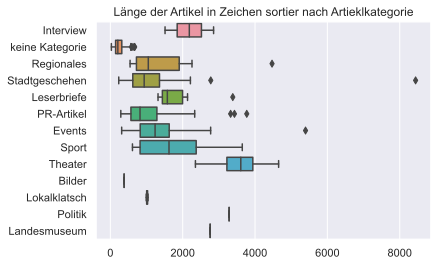

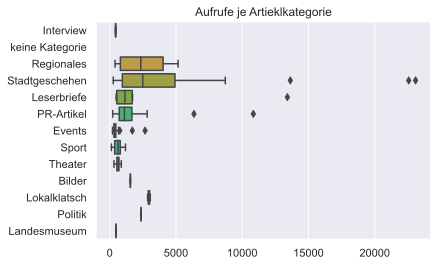

In [24]:
# Aufrufe
sns.boxplot(y='article_category', x='length_text', data=nlp_df).set(title='Länge der Artikel in Zeichen sortier nach Artieklkategorie', xlabel="", ylabel='')
plt.show()
sns.boxplot(y='article_category', x='aufrufe', data=nlp_df).set(title='Aufrufe je Artieklkategorie', xlabel="", ylabel='')
plt.show()

In [25]:
# Piepline erstellen
package_list = ["de_core_news_sm", "de_core_news_md", "de_core_news_lg"]
nlp = spacy.load(package_list[2])

In [26]:
# Variablen erstellen, die Personen, Orte erfasse 
nlp_df['Personen'] = 0
nlp_df['Orte'] = 0

nlp_df['Personen'] = nlp_df['Personen'].astype(object)
nlp_df['Orte'] = nlp_df['Orte'].astype(object)

# For-schleife zum einfügen
for i in nlp_df.index:
    local_list = []
    person_list = []
    
    doc = nlp(nlp_df['full_text'][i])
    
    # Iteriere über die vorhergesagten Entitäten
    for ent in doc.ents:
    # Drucke den Text und das Label der Entität
        if ent.label_ == 'LOC':
            local_list.append(ent.text)
        if ent.label_ == 'PER':
            person_list.append(ent.text)
    
    # In den Datensatz setzen
    nlp_df['Personen'][i] = person_list
    nlp_df['Orte'][i] = local_list
    
    print(str(len(nlp_df) - i), end="\r")
    


C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cmosa\anaconda3\envs\Scrape001\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [27]:
# Personen sichten
personen_liste = []
for sublist in nlp_df['Personen']:
    if len(sublist) == 0:
        continue
    
    for j in range(0, len(sublist)):
        personen_liste.append(sublist[j])
        


In [28]:
personen_df = pd.DataFrame({'Personen':personen_liste})
personen_df = personen_df['Personen'].value_counts()
personen_df[:10]

Britta Damaske           11
Judas                    10
Livia                     8
Susanne Bach              8
Caty Forden               6
Richard Strauss           6
Mario Block               5
Walter Plathe             5
Frauke Bohge              5
Frank Martin Widmaier     4
Name: Personen, dtype: int64

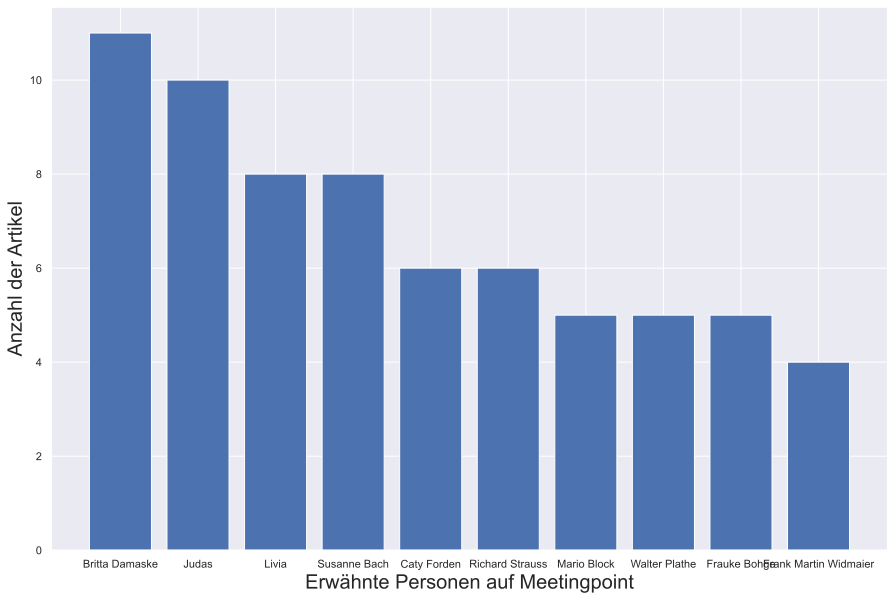

In [29]:
# Visualisieren

fig, ax = plt.subplots(figsize=(15,10))


ax.bar(personen_df[:10].index, personen_df[:10])

ax.set_xlabel('Erwähnte Personen auf Meetingpoint', fontsize=20)
ax.set_ylabel('Anzahl der Artikel', fontsize=20)

plt.show()

### Wer ist Britta Damaskte

In [30]:
britta_filter = []
nlp_df['Personen']
for i in nlp_df.index:
    if 'Britta Damaske' in nlp_df['Personen'][i]:
        britta_filter.append(True)
    else:
        britta_filter.append(False)

In [31]:
birtta_df = nlp_df[britta_filter]

In [32]:
birtta_df['full_text'][21]

'In der Serie "Unsere Läden, unsere Leute" stellt heute Britta Damaske das elegant-duftende und vielfältige Angebot der Parfümerie in der Hauptstraße 45 vor.\nIn der Welt der Düfte hat Britta Damaske eindeutig ihr Zuhause gefunden. Mit ihrer Parfümerie behauptet sie sich schon über 25 Jahre in Brandenburg. Auch, weil die Fachfrau immer nach dem Besonderen sucht – wohl wissend, dass Düfte Stil und Persönlichkeit unterstreichen. „Ich habe viele Nischenparfüms, die nicht überall zu finden sind. Das ist mein Steckenpferd“, verrät Britta Damaske.\nElegante Düfte von Hermes, transparente Düfte von Masaki Matsushima, raffinierte Düfte von Bottega oder inspirierende Düfte von Olfactive Studio – wer sich in die Parfümerie Damaske begibt, der geht wahrlich auf eine sinnliche Reise.\nWenn Britta Damaske dann noch über Parfüms redet, lässt sie ganze Welten auferstehen. Vor dem inneren Auge lichtet sich der Wald, spielt das Kind am Strand oder tobt die Seele über die Blumenwiese. „Ich liebe Düfte e

## Orte anschauen

In [33]:
# Orte sichten
orte_liste = []
for sublist in nlp_df['Orte']:
    if len(sublist) == 0:
        continue
    
    for j in range(0, len(sublist)):
        orte_liste.append(sublist[j])
        


In [34]:
orte_df = pd.DataFrame({'Personen':orte_liste})
orte_df = orte_df['Personen'].value_counts()
orte_df[10:25]

Brandenburgs               5
Stadt Brandenburg          5
Brandenburger Theater      4
Groß Kreutz                4
B1                         4
Plaue                      4
Handwerkskammer Potsdam    4
Reckahn                    4
Neuendorfer Straße         3
Wust                       3
Kloster Lehnin             3
Jeserig                    3
Havelstadt                 3
Innenstadt                 3
Wilhelmsdorfer Straße      3
Name: Personen, dtype: int64

# 4.5 Korrelationen

## 4.5.1 Korrelation Artikelart und Klickzahlen

In [35]:
stopper =

SyntaxError: invalid syntax (<ipython-input-35-45b343cc05a6>, line 1)

# AUSSCHUSS

In [ ]:
# Analyse
# fixes Beispiel

nlp = spacy.load("de_core_news_sm")
document = nlp("Peter fährt auf seinem Fahrrad und lacht")
pd.DataFrame({'Token':[word.text for word in document],
              'Grundform':[word.lemma_ for word in document],
              'Wortart':[word.pos_ for word in document]})

In [ ]:
def analyze(speech):
    with nlp.disable_pipes("tagger", "parser"):
        document = nlp(speech)
        token = [w.text for w in document]
        lemma = [w.lemma_ for w in document]
        return (token, lemma)

In [ ]:
npl_df['analysis'] = npl_df.full_text.map(analyze)
npl_df['tokens'] = npl_df.analysis.apply(lambda x: x[0])
npl_df['lemmata'] = npl_df.analysis.apply(lambda x: x[0])

In [ ]:
nlp = spacy.load("de_core_news_sm")
nlp.entity


In [ ]:
doc = nlp(npl_df['full_text'][5])

for i in range(0, len(doc.ents)):
    print(doc.ents[i], doc.ents[i].label_)

In [ ]:
npl_df